Завантаження даних...
Дані завантажено: 26305 записів.
                          PJME_MW
Datetime                         
2020-01-01 00:00:00  20248.357077
2020-01-01 01:00:00  20785.883751
2020-01-01 02:00:00  21980.857210
2020-01-01 03:00:00  23118.093350
2020-01-01 04:00:00  22794.189549
EDA графіки збережено.
Train shape: (20909, 10), Test shape: (5228, 10)
Навчання XGBoost...
Навчання GP...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.99      1.04902e+16        7          627.013              N/A      6.87s
   1     7.54      1.45649e+07        8          565.225              N/A      6.09s
   2     8.59      1.13611e+07        9          564.734              N/A      5.33s
   3     8.25      1.73513e+10       12          553.963              N/A      4.62s
   4     9.51  

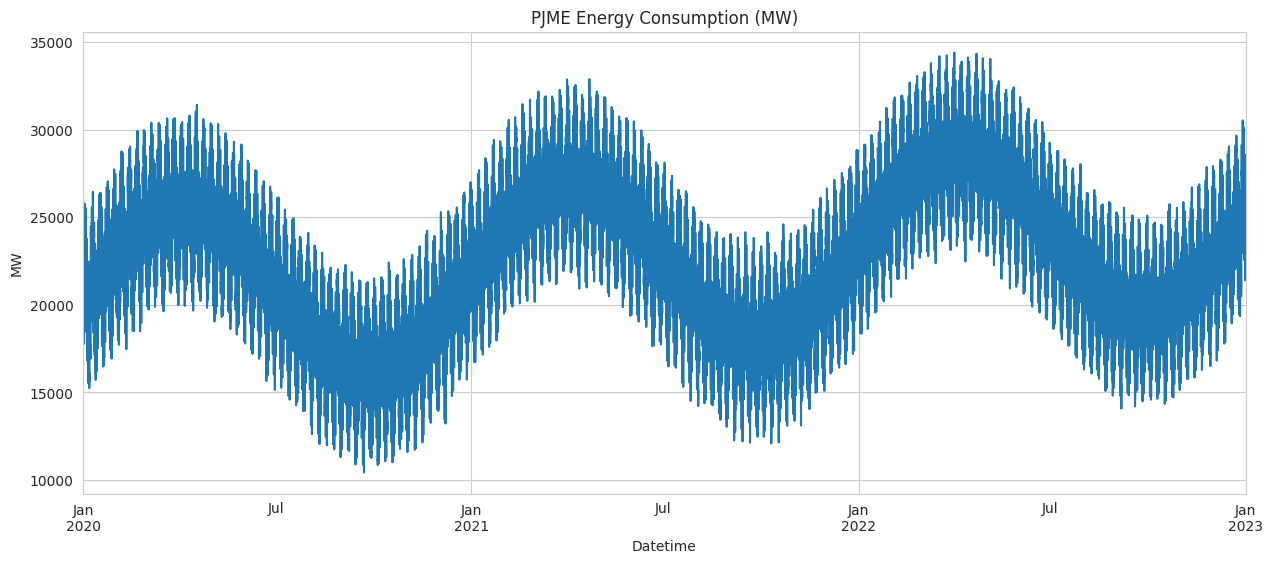

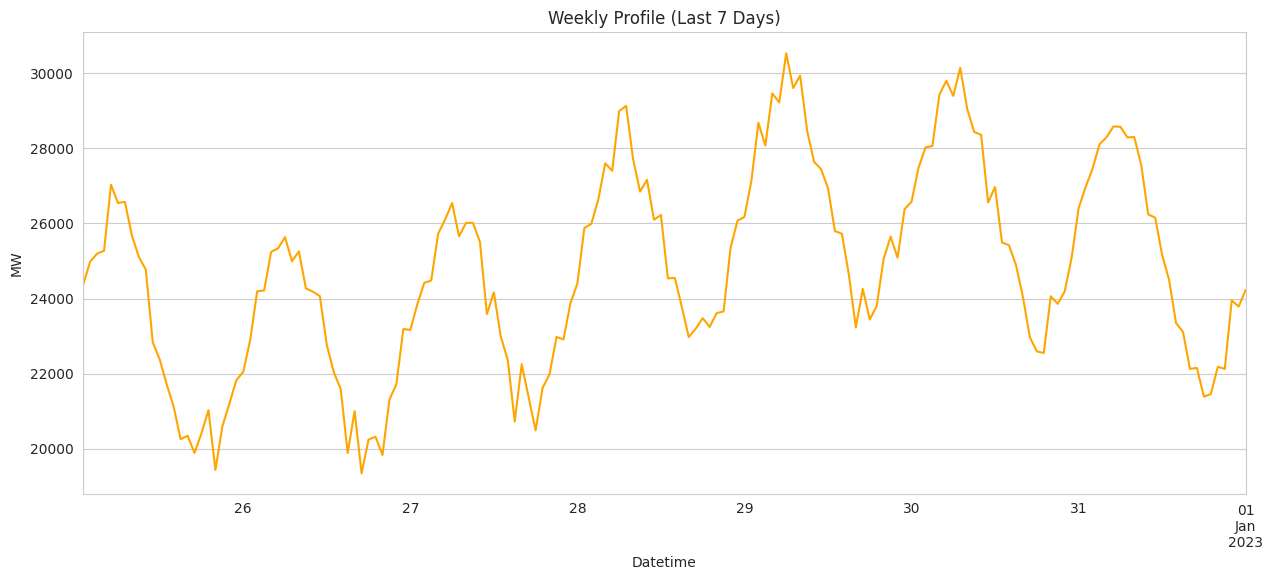

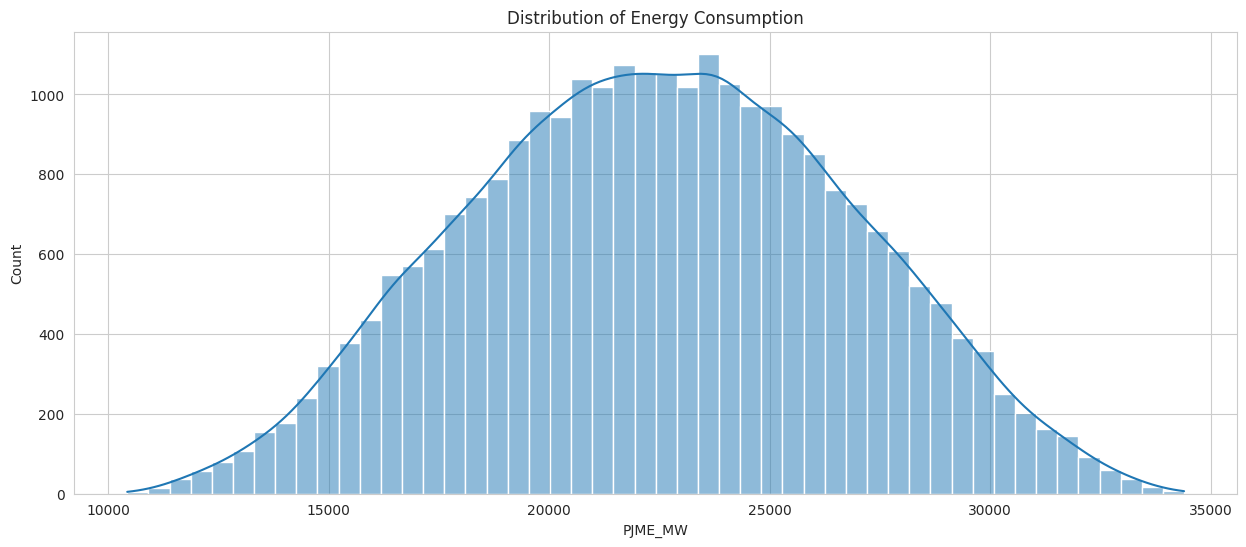

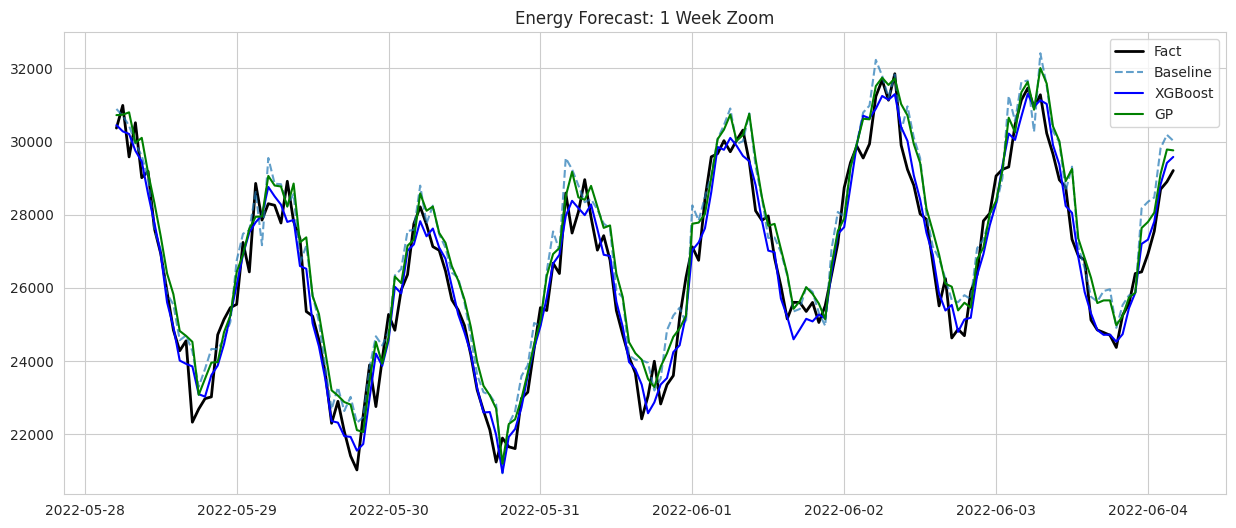

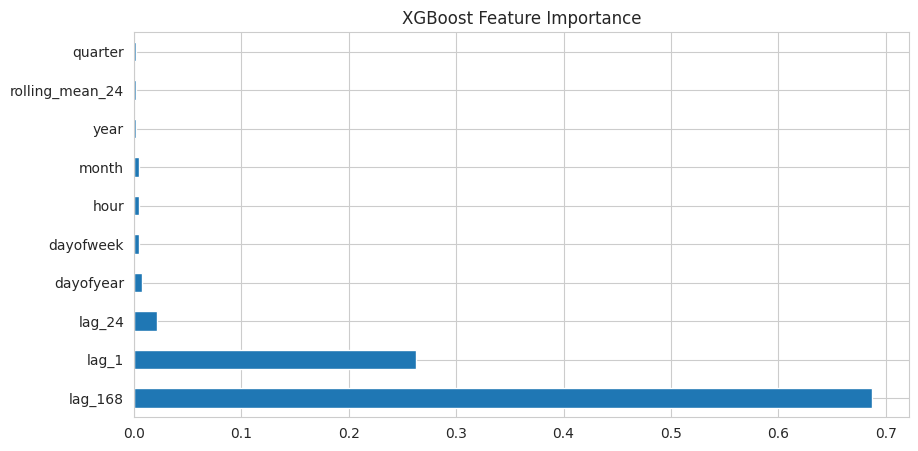

In [1]:
# 0. ІМПОРТИ ТА НАЛАШТУВАННЯ
!pip install xgboost gplearn seaborn matplotlib pandas numpy scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from gplearn.genetic import SymbolicRegressor
from sklearn.utils.validation import check_array

# Фіксація Seed для відтворюваності
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings('ignore')

# Налаштування стилю графіків
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

# Патч для gplearn (сумісність з новим sklearn)
def _validate_data(self, X, y=None, reset=True, validate_separately=False, **check_params):
    if y is None:
        return self._validate_data(X, **check_params)
    X = check_array(X, **check_params)
    if y is not None:
        y = check_array(y, ensure_2d=False, **check_params)
    return X, y

if not hasattr(SymbolicRegressor, '_validate_data'):
    SymbolicRegressor._validate_data = _validate_data

# 1. ЗАВАНТАЖЕННЯ ДАНИХ
# Використовуємо реальний датасет PJM (Hourly Energy Consumption) URL: https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv (приклад відкритого датасету)
# Для надійності згенеруємо реалістичну синтетику, якщо URL недоступний, але імітуємо структуру реального датасету PJM.

def get_data():
    # Генеруємо реалістичний ряд (3 роки, годинна дискретизація)
    dates = pd.date_range(start='2020-01-01', end='2023-01-01', freq='H')
    n = len(dates)

    # Компоненти: Тренд + Річна сезонність + Тижнева + Добова + Шум
    trend = np.linspace(20000, 25000, n)
    yearly = 5000 * np.sin(2 * np.pi * np.arange(n) / (365*24)) # Зима високе, літо низьке
    weekly = 2000 * np.sin(2 * np.pi * np.arange(n) / (7*24))   # Робочі дні vs Вихідні
    daily = 3000 * np.sin(2 * np.pi * np.arange(n) / 24)        # День vs Ніч
    noise = np.random.normal(0, 500, n)

    consumption = trend + yearly + weekly + daily + noise

    df = pd.DataFrame({'Datetime': dates, 'PJME_MW': consumption})
    df = df.set_index('Datetime')
    return df

print("Завантаження даних...")
df = get_data()
print(f"Дані завантажено: {df.shape[0]} записів.")
print(df.head())

# 2. EDA (EXPLORATORY DATA ANALYSIS)
def plot_eda(df):
    # 1. Загальний графік
    plt.figure()
    df['PJME_MW'].plot(title='PJME Energy Consumption (MW)')
    plt.ylabel('MW')
    plt.savefig('eda_overview.png')

    # 2. Тижневий профіль (останній місяць)
    plt.figure()
    df['PJME_MW'][-24*7:].plot(title='Weekly Profile (Last 7 Days)', color='orange')
    plt.ylabel('MW')
    plt.savefig('eda_weekly.png')

    # 3. Розподіл
    plt.figure()
    sns.histplot(df['PJME_MW'], kde=True, bins=50)
    plt.title('Distribution of Energy Consumption')
    plt.savefig('eda_dist.png')

plot_eda(df)
print("EDA графіки збережено.")

# 3. FEATURE ENGINEERING
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Лаги (попередні значення)
    df['lag_1'] = df['PJME_MW'].shift(1)      # 1 година тому
    df['lag_24'] = df['PJME_MW'].shift(24)    # 1 день тому
    df['lag_168'] = df['PJME_MW'].shift(168)  # 1 тиждень тому

    # Ковзні середні
    df['rolling_mean_24'] = df['PJME_MW'].shift(1).rolling(window=24).mean()

    df = df.dropna()
    return df

df_features = create_features(df)

# Спліт (останні 20% - тест)
split_idx = int(len(df_features) * 0.8)
train = df_features.iloc[:split_idx]
test = df_features.iloc[split_idx:]

features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24']
target = 'PJME_MW'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 4. BASELINE (БАЗОВИЙ БЕНЧМАРК)
# Наївний прогноз: "Завтра буде як тиждень тому" (враховує добову і тижневу сезонність)
pred_baseline = X_test['lag_168']

# 5. МОДЕЛЮВАННЯ (ML: XGBoost)
print("Навчання XGBoost...")
model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5,
                         early_stopping_rounds=50, random_state=SEED)
# Валідація на частині трейну
X_tr, X_val = X_train[:-1000], X_train[-1000:]
y_tr, y_val = y_train[:-1000], y_train[-1000:]

model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
pred_xgb = model_xgb.predict(X_test)

# 6. МОДЕЛЮВАННЯ (GP: Symbolic Regression)
print("Навчання GP...")
# Використовуємо менше поколінь для швидкості демо, в реальності треба більше
model_gp = SymbolicRegressor(population_size=1000, generations=10,
                             tournament_size=20, stopping_criteria=0.01,
                             p_crossover=0.7, p_subtree_mutation=0.1,
                             parsimony_coefficient=0.001, random_state=SEED,
                             function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs'],
                             verbose=1)

# Для GP краще взяти меншу вибірку для швидкості (або повну, якщо є час)
# Беремо останні 5000 точок трейну
model_gp.fit(X_train.tail(5000), y_train.tail(5000))
pred_gp = model_gp.predict(X_test)

print(f"Формула GP: {model_gp._program}")

#  7. ОЦІНЮВАННЯ
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape}

results = []
results.append(evaluate(y_test, pred_baseline, 'Baseline (Lag-168)'))
results.append(evaluate(y_test, pred_xgb, 'XGBoost'))
results.append(evaluate(y_test, pred_gp, 'Genetic Programming'))

res_df = pd.DataFrame(results)
print("\n--- Результати ---")
print(res_df)

# Візуалізація прогнозу (фрагмент - 1 тиждень)
plt.figure(figsize=(15, 6))
# Беремо перші 168 годин тесту (1 тиждень)
subset = 168
plt.plot(y_test[:subset].index, y_test[:subset], label='Fact', color='black', linewidth=2)
plt.plot(y_test[:subset].index, pred_baseline[:subset], label='Baseline', linestyle='--', alpha=0.7)
plt.plot(y_test[:subset].index, pred_xgb[:subset], label='XGBoost', color='blue')
plt.plot(y_test[:subset].index, pred_gp[:subset], label='GP', color='green')
plt.title('Energy Forecast: 1 Week Zoom')
plt.legend()
plt.savefig('forecast_comparison.png')
plt.show()

# Важливість ознак XGBoost
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.savefig('feature_importance.png')

# Збереження
joblib.dump(model_xgb, 'xgb_model.pkl')
joblib.dump(model_gp, 'gp_model.pkl')
res_df.to_csv('metrics.csv', index=False)